\begin{align*}
\text{Maximise:} \quad & f(x_1, x_2) = 3x_1 + 2x_2\\
\text{Subject to:} \quad
& 4x_1 + 3x_2 \leq 17 \\
& 2x_1 + 5x_2 \leq 14 \\
& x_1 \geq 0,\quad x_2 \geq 0\quad \\
& x_1, x_2 \in \mathbb{Z}
\end{align*}

In [1]:
import pickle
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

mlpObjectives = mlpResults["mlpObjectives"]
mlpAllLosses = mlpResults["mlpAllLosses"]
mlpTimes = mlpResults["mlpTimes"]
mlpSummary = mlpResults["mlpSummary"]
mlpAllCoordinates = mlpResults["mlpAllCoordinates"]
mlpAllEuclideanAccuracies = mlpResults["mlpAllEuclideanAccuracies"]
mlpAllObjectiveAccuracies = mlpResults["mlpAllObjectiveAccuracies"]

kanObjectives = kanResults["kanObjectives"]
kanAllLosses = kanResults["kanAllLosses"]
kanTimes = kanResults["kanTimes"]
kanSummary = kanResults["kanSummary"]
kanAllCoordinates = kanResults["kanAllCoordinates"]
kanAllEuclideanAccuracies = kanResults["kanAllEuclideanAccuracies"]
kanAllObjectiveAccuracies = kanResults["kanAllObjectiveAccuracies"]


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.optimize import linprog
from pulp import LpMaximize, LpProblem, LpVariable, value
from kan import *


In [3]:
c = [-3, -2]
A = [[4, 3], [2, 5]]
b = [17, 14]

lp_solution = linprog(c, A_ub=A, b_ub=b, bounds=[(0, None), (0, None)], method="highs")
x1LP, x2LP = lp_solution.x
print(f"Relaxed LP: x1 = {x1LP:.2f}, x2 = {x2LP:.2f}, Obj = {-lp_solution.fun:.2f}")

#using pulp for ILP
model = LpProblem(name="integer_lp", sense=LpMaximize)
x1 = LpVariable("x1", lowBound=0, cat="Integer")
x2 = LpVariable("x2", lowBound=0, cat="Integer")
model += 3*x1 + 2*x2
model += 4*x1 + 3*x2 <= 17
model += 2*x1 + 5*x2 <= 14
model.solve()
x1Int, x2Int = x1.varValue, x2.varValue
xAnalytical = [x1Int, x2Int]
objAnalytical = value(model.objective)
print(f"Integer Solution: x1 = {x1Int}, x2 = {x2Int}, Obj = {objAnalytical:.2f}")

Relaxed LP: x1 = 4.25, x2 = 0.00, Obj = 12.75
Integer Solution: x1 = 4.0, x2 = 0.0, Obj = 12.00


In [4]:
#generating samples

A = torch.tensor([[4, 3], [2, 5]], dtype=torch.float32)
b = torch.tensor([17, 14], dtype=torch.float32)

def objectiveFunction(x):
    return 3 * x[0] + 2 * x[1]

def constraint1(x): return 4 * x[0] + 3 * x[1] <= 17
def constraint2(x): return 2 * x[0] + 5 * x[1] <= 14
def nonNegativity(x): return (x[0] >= 0) & (x[1] >= 0)

def generateFeasibleSamples(nSamples=1000, xRange=(0, 10)):
    samples = []
    for _ in range(nSamples * 2):
        x1 = np.random.randint(xRange[0], xRange[1] + 1)
        x2 = np.random.randint(xRange[0], xRange[1] + 1)
        x = torch.tensor([x1, x2], dtype=torch.float32)
        if constraint1(x) and constraint2(x) and nonNegativity(x):
            samples.append(x)
        if len(samples) >= nSamples:
            break

    data = torch.stack(samples)
    targets = objectiveFunction(data)

    return data, targets

In [21]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.fc(x)

# Training settings
mlpNRuns = 5
mlpEpochs = 20000
learningRate = 0.001
mlpAllLosses = []
mlpObjectives, mlpLosses = [], []
lossCurves = []
mlpSummary = []
mlpAllEuclideanAccuracies = []
mlpAllObjectiveAccuracies = []
mlpAllCoordinates = []

for run in range(mlpNRuns):
    torch.manual_seed(run)

    # Generate training data
    xTrain, yTrain = generateFeasibleSamples(1000)
    yTrain = (yTrain - yTrain.mean()) / yTrain.std()
    yTrain = yTrain.unsqueeze(1)

    mlpModel = MLP()
    optimiser = optim.AdamW(mlpModel.parameters(), lr=learningRate)

    mlpRunLosses = []
    mlpRunEuclideanAccuracies = []
    mlpRunObjectiveAccuracies = []
    mlpRunCoordinates = []

    mlpStartTime = time.time()

    for epoch in range(mlpEpochs):
        mlpModel.train()
        optimiser.zero_grad()
        predictions = mlpModel(xTrain)
        mseLoss = torch.mean((predictions - yTrain.squeeze()) ** 2)

        #combine loss
        loss = mseLoss - 0.1 * predictions.mean() 
        loss.backward()
        optimiser.step()
        mlpRunLosses.append(loss.item())

        with torch.no_grad():
            mlpModel.eval()
            predictions = mlpModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            bestX = xTrain[bestPrediction]
            mlpRunCoordinates.append(bestX)
            mlpBestVal = objectiveFunction(bestX).item()
            mlpBestX1 = bestX[0].item()
            mlpBestX2 = bestX[1].item()
            euclideanDistance = torch.norm(torch.tensor([mlpBestX1, mlpBestX2]) - torch.tensor([xAnalytical[0], xAnalytical[1]])).item()
            mlpRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(mlpBestVal - objAnalytical)
            mlpRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    mlpAllLosses.append(mlpRunLosses)
    mlpAllCoordinates.append(mlpRunCoordinates)
    mlpAllEuclideanAccuracies.append(mlpRunEuclideanAccuracies)
    mlpAllObjectiveAccuracies.append(mlpRunObjectiveAccuracies)        
    mlpEndTime = time.time()

    print(f"Run {run + 1}: Best x1 = {bestX[0].item():.0f}, x2 = {bestX[1].item():.0f} → Objective = {mlpBestVal:.2f}")
    
    mlpObjectives.append(mlpBestVal)
    mlpLosses.append(mlpRunLosses[-1])
    lossCurves.append(mlpRunLosses)
    mlpSummary.append({
        "objective": mlpBestVal,
        "finalLoss": mlpRunLosses[-1],
        "time": mlpEndTime - mlpStartTime,
        "x1": mlpBestX1,
        "x2": mlpBestX2
    })

#extracting metrics
mlpObjectives = [r["objective"] for r in mlpSummary]
mlpLosses = [r["finalLoss"] for r in mlpSummary]
mlpTimes = [r["time"] for r in mlpSummary]
mlpX1Vals = [r["x1"] for r in mlpSummary]
mlpX2Vals = [r["x2"] for r in mlpSummary]

print(f"Mean Objective Value: {np.mean(mlpObjectives):.4f} +- {np.std(mlpObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(mlpLosses):.4f} +- {np.std(mlpLosses):.4f}")
print(f"Mean Time:            {np.mean(mlpTimes):.4f}s +- {np.std(mlpTimes):.4f}s")



Run 1: Best x1 = 2, x2 = 2 → Objective = 10.00
Run 2: Best x1 = 4, x2 = 0 → Objective = 12.00
Run 3: Best x1 = 1, x2 = 0 → Objective = 3.00
Run 4: Best x1 = 2, x2 = 2 → Objective = 10.00
Run 5: Best x1 = 3, x2 = 0 → Objective = 9.00
Mean Objective Value: 8.8000 +- 3.0594
Mean Final Loss:      0.4975 +- 0.0000
Mean Time:            76.3716s +- 13.3797s


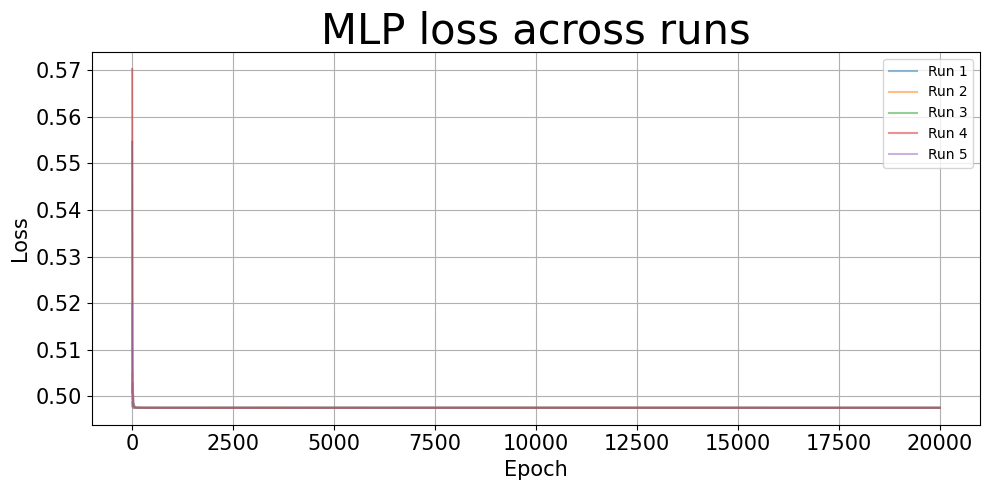

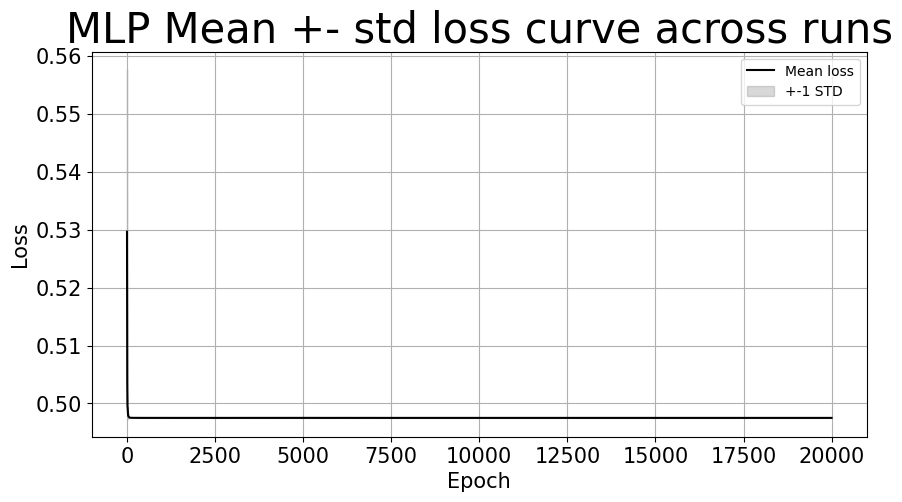

In [5]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP loss across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

mlpLossArray = np.array(mlpAllLosses)
mlpMeanLoss = np.mean(mlpLossArray, axis=0)
mlpStdLoss = np.std(mlpLossArray, axis=0)

#mean and standard deviation of losses over all runs
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="Mean loss", color='black')
plt.fill_between(range(20000), mlpMeanLoss - mlpStdLoss, mlpMeanLoss + mlpStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP Mean +- std loss curve across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.show()

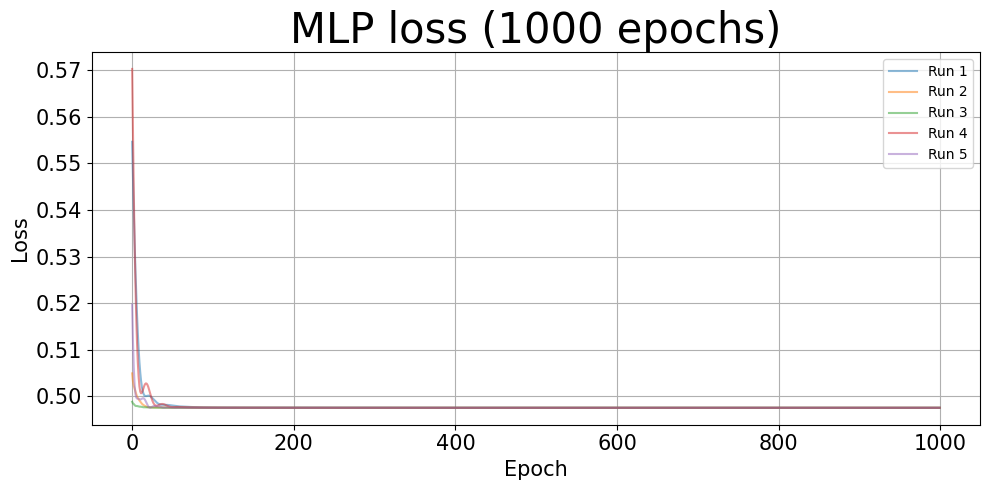

In [6]:
#loss graph restricted to 1000 epochs
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP loss (1000 epochs)", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

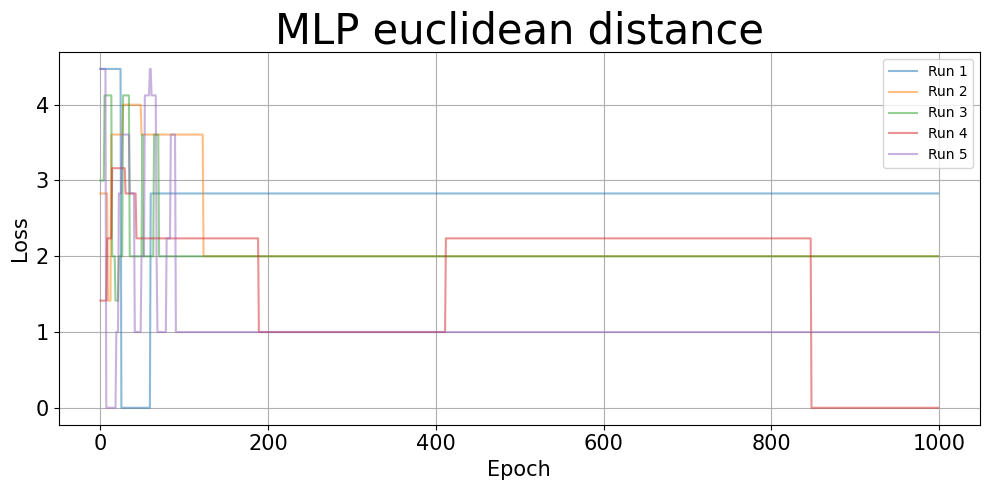

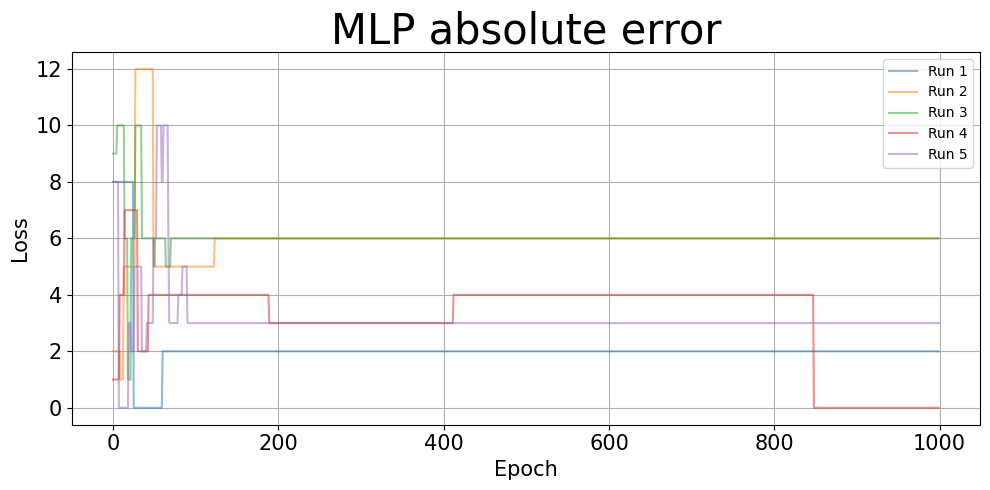

In [7]:
#euclidean distance over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllEuclideanAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#absolute error over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllObjectiveAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


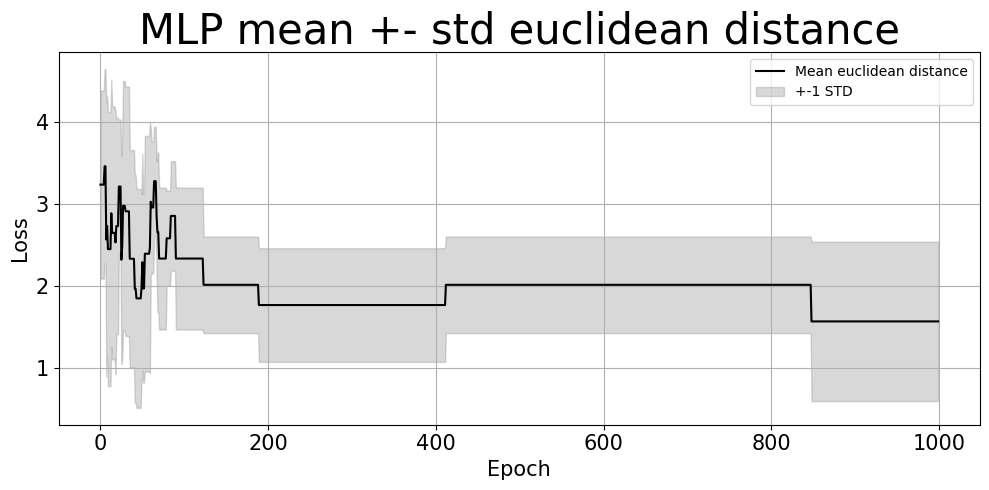

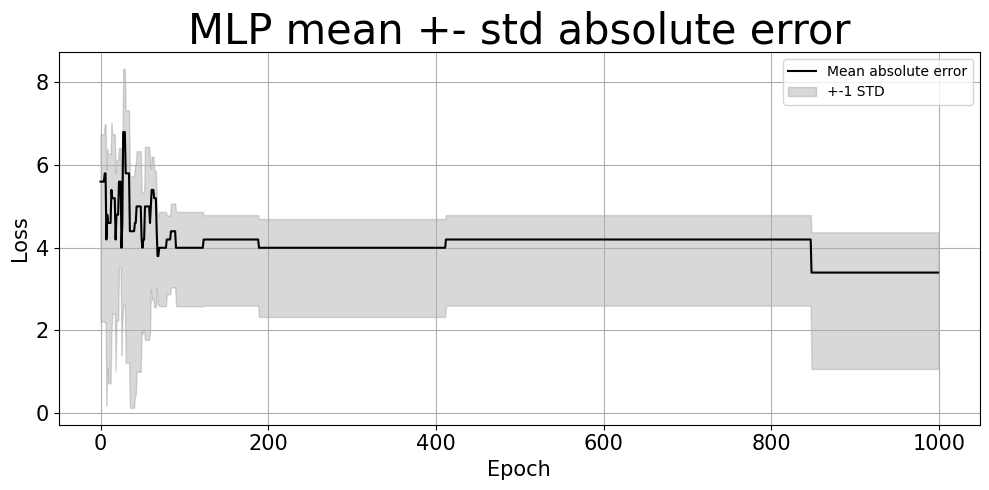

In [8]:
mlpEuclideanAccuracyArray = np.array(mlpAllEuclideanAccuracies)
mlpMeanEuclideanAccuracy = np.mean(mlpEuclideanAccuracyArray, axis=0)
mlpStdEuclideanAccuracy = np.std(mlpEuclideanAccuracyArray, axis=0)

#mean and std of euclidean distance
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:1000], label="Mean euclidean distance", color='black')
plt.fill_between(range(1000), mlpMeanEuclideanAccuracy[:1000] - mlpStdEuclideanAccuracy[:1000], mlpMeanEuclideanAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP mean +- std euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

mlpObjectiveAccuracyArray = np.array(mlpAllObjectiveAccuracies)
mlpMeanObjectiveAccuracy = np.mean(mlpObjectiveAccuracyArray, axis=0)
mlpStdObjectiveAccuracy = np.std(mlpObjectiveAccuracyArray, axis=0)

#mean and std of absolute error
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:1000], label="Mean absolute error", color='black')
plt.fill_between(range(1000), mlpMeanObjectiveAccuracy[:1000] - mlpStdObjectiveAccuracy[:1000], mlpMeanObjectiveAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP mean +- std absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
kanNRuns = 5
kanEpochs = 1000
kanAllLosses = []
kanSummary = []
kanAllEuclideanAccuracies = []
kanAllObjectiveAccuracies = []
kanAllCoordinates = []

for i in range(kanNRuns):
    torch.manual_seed(i)
    np.random.seed(i)
    xTrain, yTrain = generateFeasibleSamples(1000)
    yTrain = yTrain.unsqueeze(1)
    kanModel = KAN(width=[2, 3, 3, 1], grid=3, k=3, seed=i)
    optimiser = optim.Adam(kanModel.parameters(), lr=0.001)

    runLosses = []
    kanRunEuclideanAccuracies = []
    kanRunObjectiveAccuracies = []
    kanRunCoordinates = []
    startTime = time.time()

    for epoch in range(kanEpochs):
        if epoch == 500:
            kanModel.refine(10)
        kanModel.train()
        optimiser.zero_grad()

        predictions = kanModel(xTrain)
        mseLoss = torch.mean((predictions - yTrain.squeeze()) ** 2)

        loss = mseLoss -0.1 * predictions.mean()

        loss.backward()
        optimiser.step()
        runLosses.append(loss.item())
    
        with torch.no_grad():
            kanModel.eval()
            predictions = kanModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            kanBestX = xTrain[bestPrediction]
            kanRunCoordinates.append(kanBestX)
            bestVal = objectiveFunction(kanBestX).item()
            kanBestX1 = kanBestX[0].item()
            kanBestX2 = kanBestX[1].item()
            euclideanDistance = torch.norm(torch.tensor([kanBestX1, kanBestX2]) - torch.tensor([xAnalytical[0], xAnalytical[1]])).item()
            kanRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(bestVal - objAnalytical)
            kanRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    endTime = time.time()
    kanAllLosses.append(runLosses)
    kanAllCoordinates.append(kanRunCoordinates)
    kanAllEuclideanAccuracies.append(kanRunEuclideanAccuracies)
    kanAllObjectiveAccuracies.append(kanRunObjectiveAccuracies)
    kanSummary.append({
        "objective": bestVal,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "x1": kanBestX1,
        "x2": kanBestX2
    })

    print(f"Run {i+1}: Best x1 = {kanBestX1:.4f}, x2 = {kanBestX2:.4f} → Objective = {bestVal:.4f}, Loss = {runLosses[-1]:.4f}")
#metrics
kanObjectives = [r["objective"] for r in kanSummary]
kanLosses = [r["finalLoss"] for r in kanSummary]
kanTimes = [r["time"] for r in kanSummary]
kanX1Vals = [r["x1"] for r in kanSummary]
kanX2Vals = [r["x2"] for r in kanSummary]

print(f"Mean Objective Value: {np.mean(kanObjectives):.4f} +- {np.std(kanObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(kanLosses):.4f} +- {np.std(kanLosses):.4f}")
print(f"Mean Time:            {np.mean(kanTimes):.4f}s +- {np.std(kanTimes):.4f}s")


checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 1: Best x1 = 4.0000, x2 = 0.0000 → Objective = 12.0000, Loss = 5.6008
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 2: Best x1 = 2.0000, x2 = 2.0000 → Objective = 10.0000, Loss = 0.8978
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 3: Best x1 = 3.0000, x2 = 0.0000 → Objective = 9.0000, Loss = 19.4999
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 4: Best x1 = 1.0000, x2 = 0.0000 → Objective = 3.0000, Loss = 0.5438
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 5: Best x1 = 4.0000, x2 = 0.0000 → Objective = 12.0000, Loss = 11.5188
Mean Objective Value: 9.2000 +- 3.3106
Mean Final Loss:      7.6122 +- 7.1508
Mean Time:            45.6012s +- 5.6802s


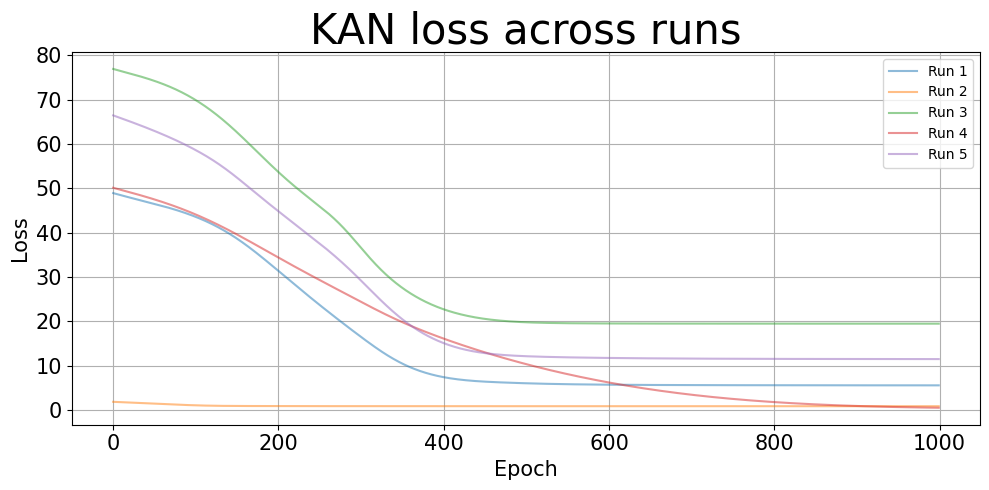

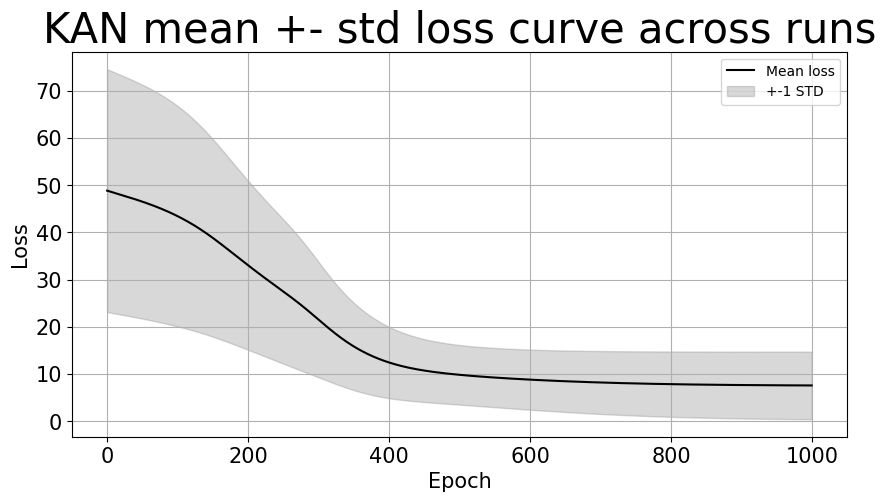

In [ ]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(kanAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN loss across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#graph of mean +- std of loss
kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanLoss, label="Mean loss", color='black')
plt.fill_between(range(1000), kanMeanLoss - kanStdLoss, kanMeanLoss + kanStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std loss curve across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.show()


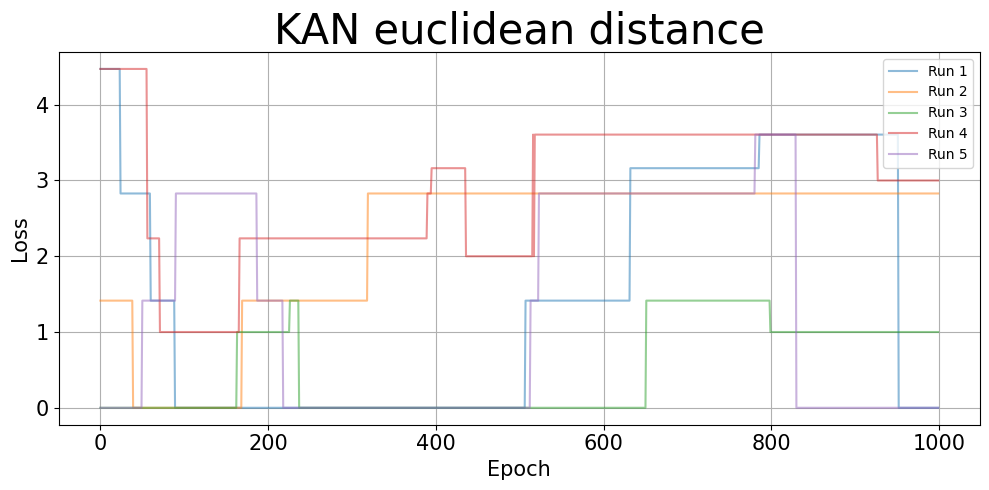

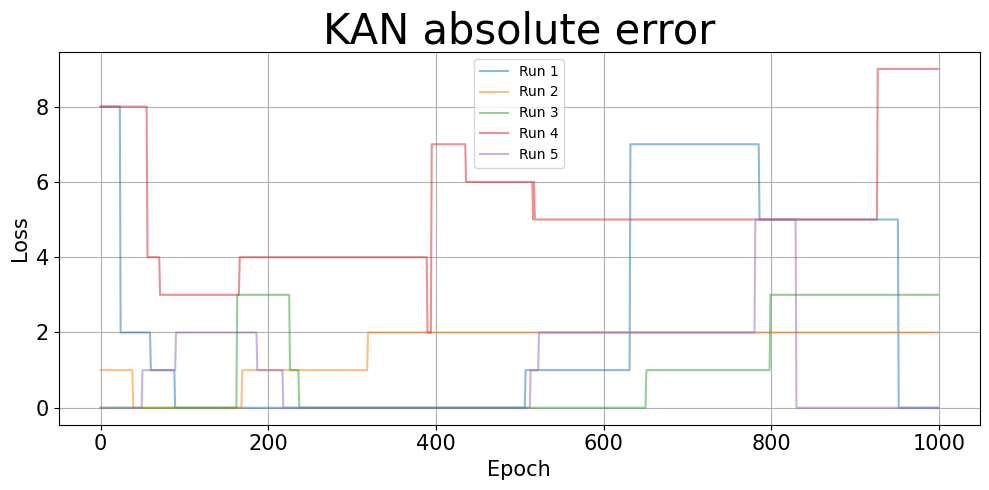

In [10]:
#kan euclidean distance across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllEuclideanAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#kan absolute error across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllObjectiveAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



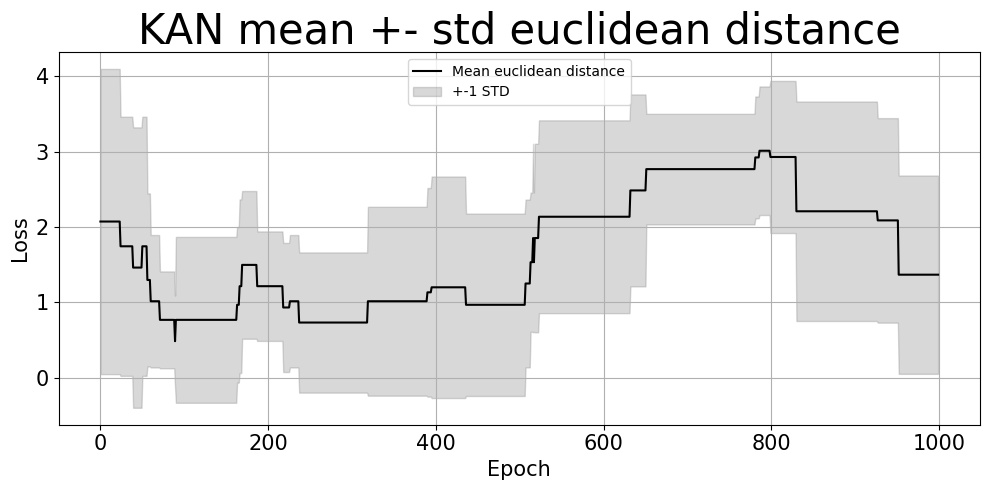

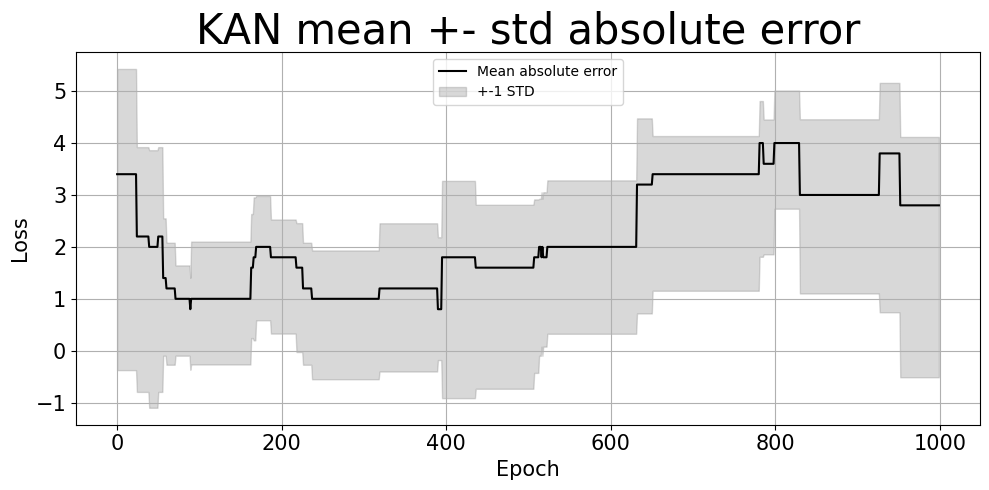

In [11]:
kanEuclideanAccuracyArray = np.array(kanAllEuclideanAccuracies)
kanMeanEuclideanAccuracy = np.mean(kanEuclideanAccuracyArray, axis=0)
kanStdEuclideanAccuracy = np.std(kanEuclideanAccuracyArray, axis=0)

#mean and std of euclidean distance
plt.figure(figsize=(10, 5))
plt.plot(kanMeanEuclideanAccuracy[:1000], label="Mean euclidean distance", color='black')
plt.fill_between(range(1000), kanMeanEuclideanAccuracy[:1000] - kanStdEuclideanAccuracy[:1000], kanMeanEuclideanAccuracy[:1000] + kanStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

kanObjectiveAccuracyArray = np.array(kanAllObjectiveAccuracies)
kanMeanObjectiveAccuracy = np.mean(kanObjectiveAccuracyArray, axis=0)
kanStdObjectiveAccuracy = np.std(kanObjectiveAccuracyArray, axis=0)

#mean and std of absolute error
plt.figure(figsize=(10, 5))
plt.plot(kanMeanObjectiveAccuracy[:1000], label="Mean absolute error", color='black')
plt.fill_between(range(1000), kanMeanObjectiveAccuracy[:1000] - kanStdObjectiveAccuracy[:1000], kanMeanObjectiveAccuracy[:1000] + kanStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<b>Saving results to pickle files</b>  
If the values in the notebook are ever lost, I can just load the existing results instead of running everything again.  
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

In [29]:
import pickle

mlpResults = {
    "mlpObjectives": mlpObjectives,
    "mlpAllLosses": mlpAllLosses,
    "mlpTimes": mlpTimes,
    "mlpSummary": mlpSummary,
    "mlpAllCoordinates": mlpAllCoordinates,
    "mlpAllEuclideanAccuracies": mlpAllEuclideanAccuracies,
    "mlpAllObjectiveAccuracies": mlpAllObjectiveAccuracies
}

with open('mlpResults.pkl', 'wb') as f:
    pickle.dump(mlpResults, f)

kanResults = {
    "kanObjectives": kanObjectives,
    "kanAllLosses": kanAllLosses,
    "kanTimes": kanTimes,
    "kanSummary": kanSummary,
    "kanAllCoordinates": kanAllCoordinates,
    "kanAllEuclideanAccuracies": kanAllEuclideanAccuracies,
    "kanAllObjectiveAccuracies": kanAllObjectiveAccuracies
}

with open('kanResults.pkl', 'wb') as f:
    pickle.dump(kanResults, f)

In [30]:
#getting convergence speed
def computeConvergenceSpeed(allLosses, thresholdRatio=0.05):
    speeds = []
    for lossCurve in allLosses:
        finalLoss = lossCurve[-1]
        threshold = finalLoss * (1 + thresholdRatio)
        for i, loss in enumerate(lossCurve):
            if loss <= threshold:
                speeds.append(i)
                break
    return speeds

mlpConvergence = computeConvergenceSpeed(mlpAllLosses)
kanConvergence = computeConvergenceSpeed(kanAllLosses)

#model complexity - this is based on the parameter count for each
mlpParamCount = sum(p.numel() for p in mlpModel.parameters())
kanParamCount = sum(p.numel() for p in kanModel.parameters())

mlpBestObjective = np.max(mlpObjectives)
kanBestObjective = np.max(kanObjectives)



In [31]:
#metric comparison table
comparisonData = {
    "Metric": [
        "Mean Objective Value",
        "Std Objective Value",
        "Best Objective Value",
        "Mean Final Loss",
        "Std Final Loss",
        "Mean Time (s)",
        "Std Time (s)",
        "Mean Convergence Epoch",
        "Std Convergence Epoch",
        "Model Parameters"
    ],
    "MLP": [
        np.mean(mlpObjectives),
        np.std(mlpObjectives),
        mlpBestObjective,
        np.mean(mlpLosses),
        np.std(mlpLosses),
        np.mean(mlpTimes),
        np.std(mlpTimes),
        np.mean(mlpConvergence),
        np.std(mlpConvergence),
        mlpParamCount
    ],
    "KAN": [
        np.mean(kanObjectives),
        np.std(kanObjectives),
        kanBestObjective,
        np.mean(kanLosses),
        np.std(kanLosses),
        np.mean(kanTimes),
        np.std(kanTimes),
        np.mean(kanConvergence),
        np.std(kanConvergence),
        kanParamCount
    ]
}

comparisonDf = pd.DataFrame(comparisonData)
display(comparisonDf)


,Metric,MLP,KAN
0,Mean Objective Value,8.800000e+00,9.200000
1,Std Objective Value,3.059412e+00,3.310589
2,Best Objective Value,1.200000e+01,12.000000
3,Mean Final Loss,4.975001e-01,7.612226
4,Std Final Loss,2.460452e-07,7.150828
5,Mean Time (s),7.637156e+01,45.601174
6,Std Time (s),1.337965e+01,5.680167
7,Mean Convergence Epoch,2.000000e+00,531.600000
8,Std Convergence Epoch,2.449490e+00,265.208295
9,Model Parameters,1.185000e+03,360.000000


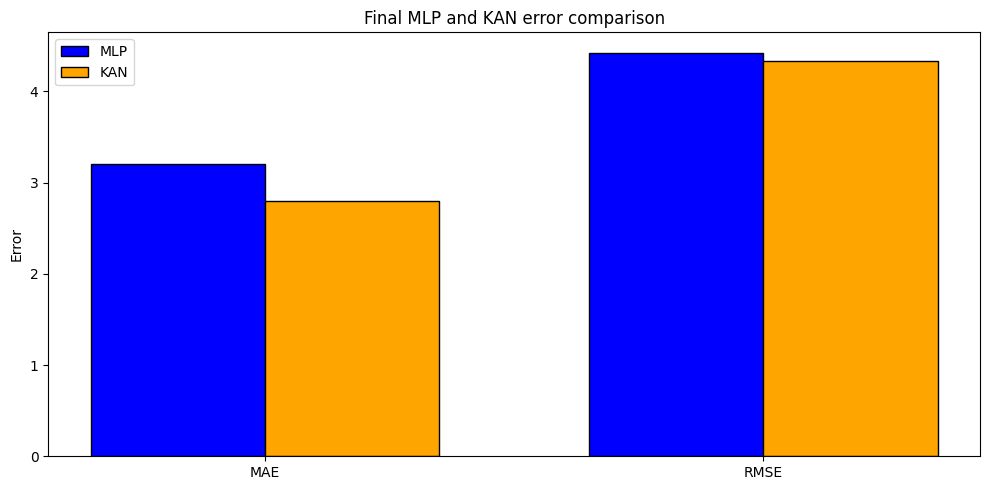

In [12]:
mlpMeanAbsError = abs(np.mean(mlpObjectives) - objAnalytical)
kanMeanAbsError = abs(np.mean(kanObjectives) - objAnalytical)
mlpRMSE = np.sqrt(np.mean((np.array(mlpObjectives) - objAnalytical)**2))
kanRMSE = np.sqrt(np.mean((np.array(kanObjectives) - objAnalytical)**2))

metrics = ['MAE', 'RMSE']
mlpErrors = [mlpMeanAbsError, mlpRMSE]
kanErrors = [kanMeanAbsError, kanRMSE]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, mlpErrors, width, label='MLP', color='blue', edgecolor='black')
plt.bar(x + width/2, kanErrors, width, label='KAN', color='orange', edgecolor='black')

plt.ylabel('Error')
plt.title('Final MLP and KAN error comparison')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\A\AppData\Local\Temp\ipykernel_8100\2367243651.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


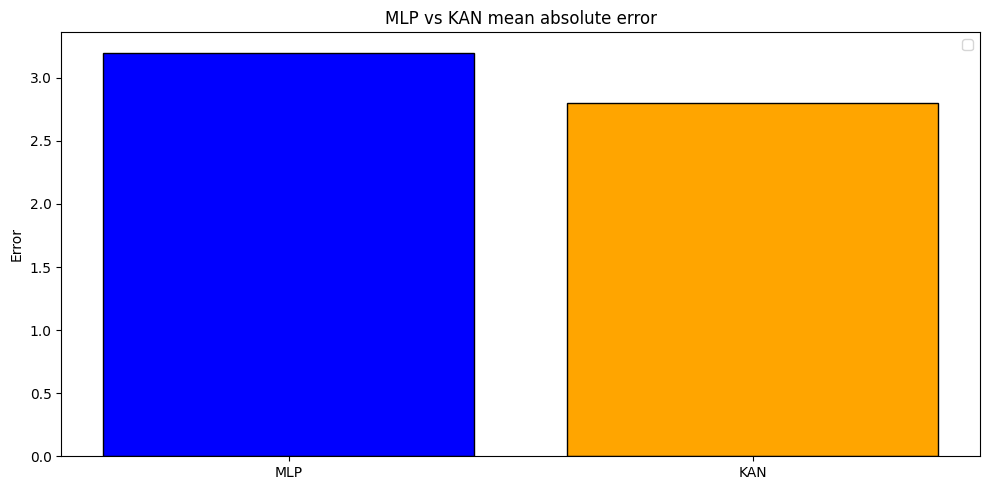

In [13]:
plt.figure(figsize=(10, 5))
plt.bar("MLP", mlpMeanAbsError, color='blue', edgecolor='black')
plt.bar("KAN", kanMeanAbsError, color='orange', edgecolor='black')
plt.ylabel('Error')
plt.title("MLP vs KAN mean absolute error")
plt.legend()
plt.tight_layout()
plt.show()


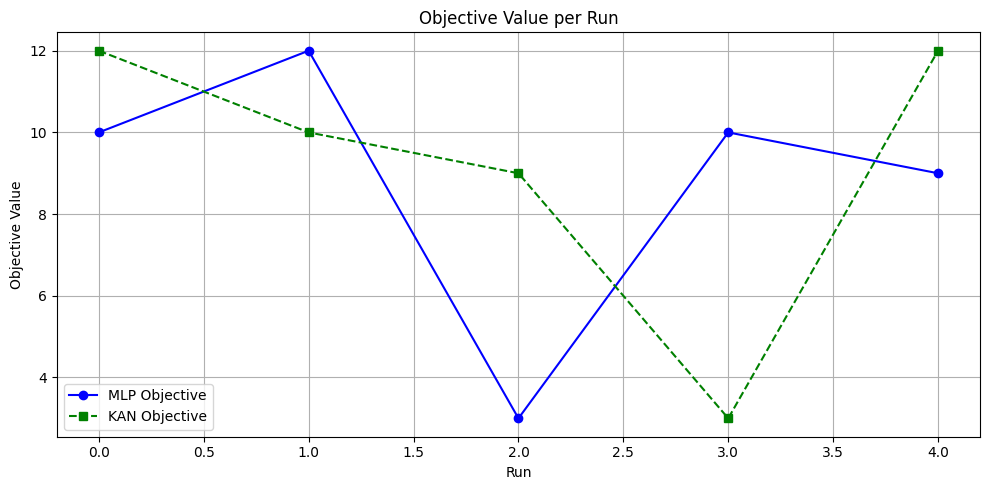

In [32]:
#objective value across models
plt.figure(figsize=(10, 5))
plt.plot(mlpObjectives, 'o-', label="MLP Objective", color='blue')
plt.plot(kanObjectives, 's--', label="KAN Objective", color='green')
plt.title("Objective Value per Run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

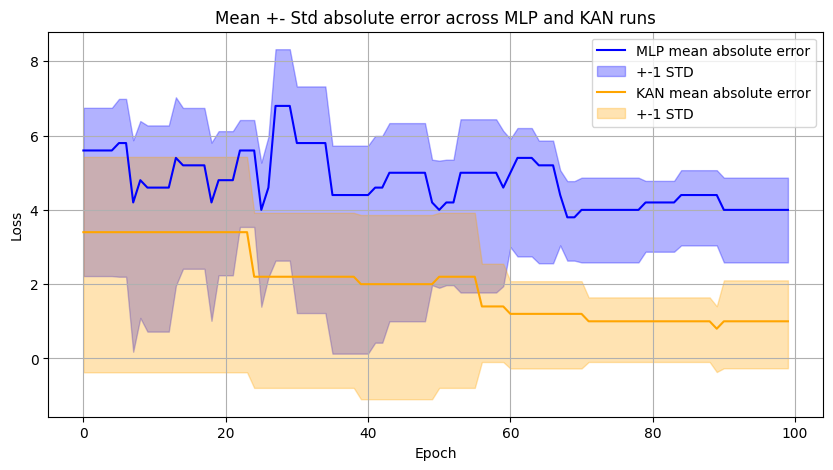

In [ ]:
#absolute error comparison
start = 0
epochLimit = 100
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanObjectiveAccuracy[start:epochLimit], label="MLP mean absolute error", color='blue')
plt.fill_between(epochs, mlpMeanObjectiveAccuracy[start:epochLimit] - mlpStdObjectiveAccuracy[start:epochLimit], mlpMeanObjectiveAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanObjectiveAccuracy[start:epochLimit], label="KAN mean absolute error", color='orange')
plt.fill_between(epochs, kanMeanObjectiveAccuracy[start:epochLimit] - kanStdObjectiveAccuracy[start:epochLimit], kanMeanObjectiveAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std absolute error across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

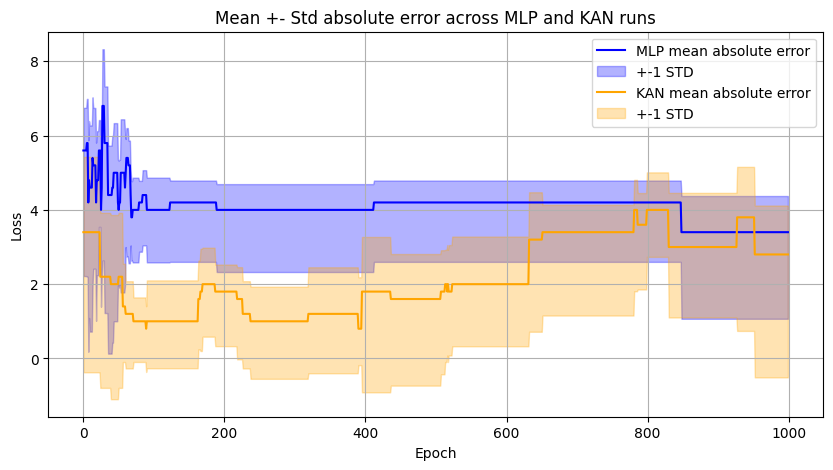

In [15]:
#absolute error comparison
start = 0
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanObjectiveAccuracy[start:epochLimit], label="MLP mean absolute error", color='blue')
plt.fill_between(epochs, mlpMeanObjectiveAccuracy[start:epochLimit] - mlpStdObjectiveAccuracy[start:epochLimit], mlpMeanObjectiveAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanObjectiveAccuracy[start:epochLimit], label="KAN mean absolute error", color='orange')
plt.fill_between(epochs, kanMeanObjectiveAccuracy[start:epochLimit] - kanStdObjectiveAccuracy[start:epochLimit], kanMeanObjectiveAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std absolute error across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

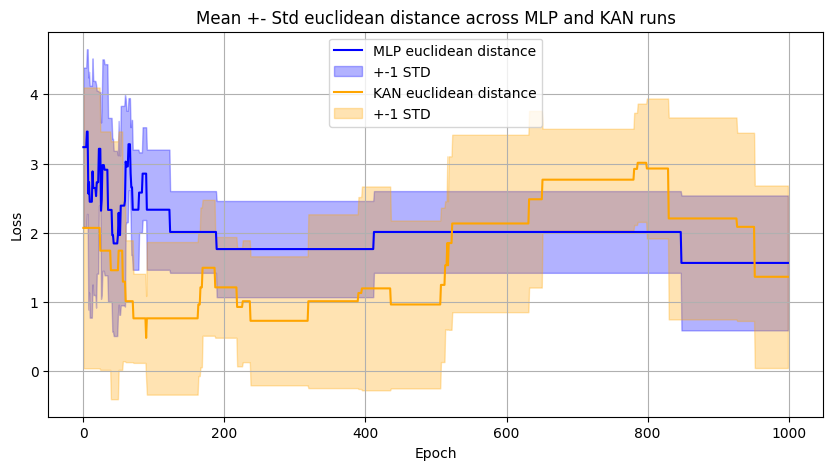

In [16]:
#euclidean distance comparison
start = 0
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanEuclideanAccuracy[start:epochLimit], label="MLP euclidean distance", color='blue')
plt.fill_between(epochs, mlpMeanEuclideanAccuracy[start:epochLimit] - mlpStdEuclideanAccuracy[start:epochLimit], mlpMeanEuclideanAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanEuclideanAccuracy[start:epochLimit], label="KAN euclidean distance", color='orange')
plt.fill_between(epochs, kanMeanEuclideanAccuracy[start:epochLimit] - kanStdEuclideanAccuracy[start:epochLimit], kanMeanEuclideanAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std euclidean distance across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

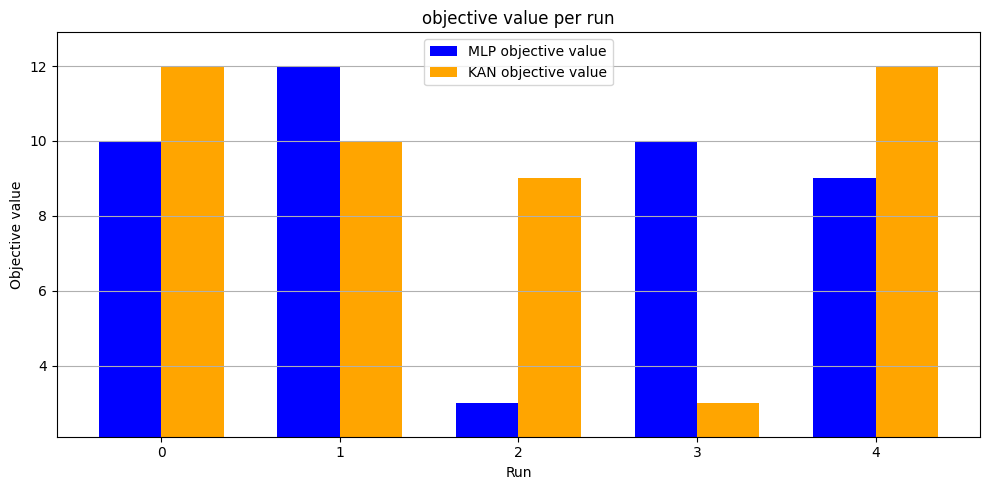

In [17]:
#bar graph of objective values in each run
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpObjectives, width=bar_width, label="MLP objective value", color='blue')
plt.bar(runs + offset, kanObjectives, width=bar_width, label="KAN objective value", color='orange')

plt.title("objective value per run")
plt.xlabel("Run")
plt.ylabel("Objective value")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
minVal = min(min(mlpObjectives), min(kanObjectives))
maxVal = max(max(mlpObjectives), max(kanObjectives))
padding = (maxVal - minVal) * 0.1
plt.ylim(minVal - padding, maxVal + padding)
plt.tight_layout()
plt.show()

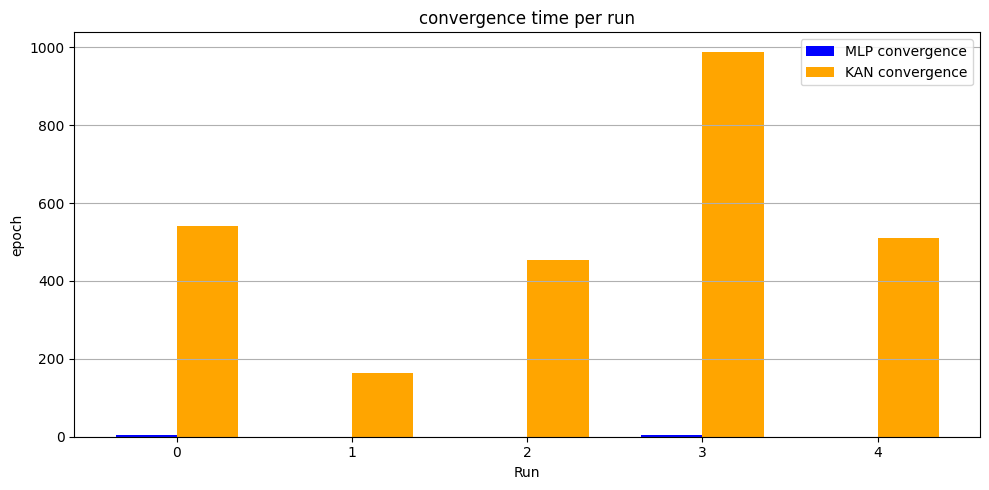

In [36]:
#convergence time comparison
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpConvergence, width=bar_width, label="MLP convergence", color='blue')
plt.bar(runs + offset, kanConvergence, width=bar_width, label="KAN convergence", color='orange')

plt.title("convergence time per run")
plt.xlabel("Run")
plt.ylabel("epoch")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

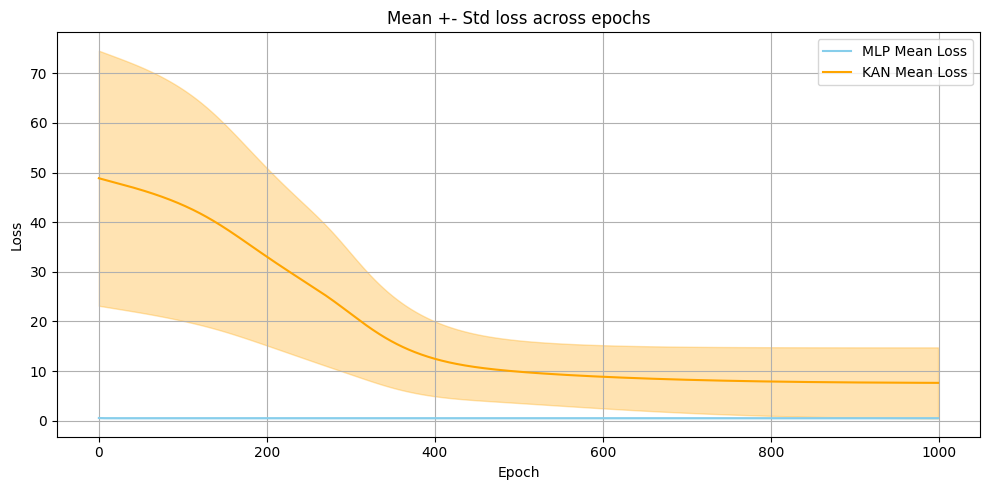

In [18]:
#loss comparison
mlpLossArray = np.array(mlpAllLosses)
kanLossArray = np.array(kanAllLosses)

mlpMeanLoss = np.mean(mlpLossArray, axis=0)[:1000]
mlpStdLoss = np.std(mlpLossArray, axis=0)[:1000]

kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="MLP Mean Loss", color='skyblue')
plt.fill_between(range(len(mlpMeanLoss)),
                 mlpMeanLoss - mlpStdLoss,
                 mlpMeanLoss + mlpStdLoss,
                 alpha=0.3, color='skyblue')

plt.plot(kanMeanLoss, label="KAN Mean Loss", color='orange')
plt.fill_between(range(len(kanMeanLoss)),
                 kanMeanLoss - kanStdLoss,
                 kanMeanLoss + kanStdLoss,
                 alpha=0.3, color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std loss across epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
mlpBestPrediction = np.argmax(mlpObjectives)
kanBestPrediction = np.argmax(kanObjectives)
mlpBestX1 = mlpX1Vals[mlpBestPrediction]
mlpBestX2 = mlpX2Vals[mlpBestPrediction]
kanBestX1 = kanX1Vals[kanBestPrediction]
kanBestX2 = kanX2Vals[kanBestPrediction]

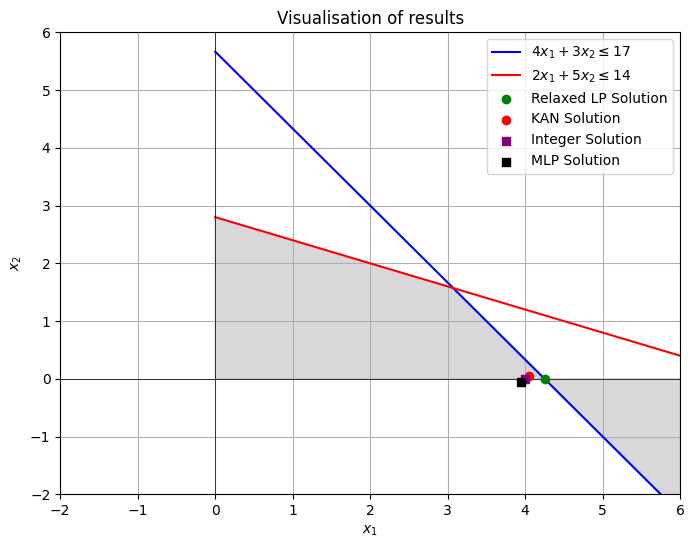

In [ ]:
xVals = np.linspace(0, 10, 200)
y1Vals = (17 - 4*xVals) / 3
y2Vals = (14 - 2*xVals) / 5

offset = 0.05
plt.figure(figsize=(8, 6))
plt.plot(xVals, y1Vals, label=r"$4x_1 + 3x_2 \leq 17$", color="blue")
plt.plot(xVals, y2Vals, label=r"$2x_1 + 5x_2 \leq 14$", color="red")
plt.fill_between(xVals, np.minimum(y1Vals, y2Vals), 0, color="gray", alpha=0.3)

plt.scatter(x1LP, x2LP, color="green", label="Relaxed LP Solution", zorder=3)
plt.scatter(kanBestX1+offset, kanBestX2+offset, color="red", label="KAN Solution", zorder=3)
plt.scatter(x1Int, x2Int, color="purple", label="Integer Solution", zorder=3, marker="s")
plt.scatter(mlpBestX1-offset, mlpBestX2-offset, color="black", label="MLP Solution", zorder=3, marker="s")

plt.xlim(-2, 6)
plt.ylim(-2, 6)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.title("Visualisation of results")
plt.grid()
plt.show()

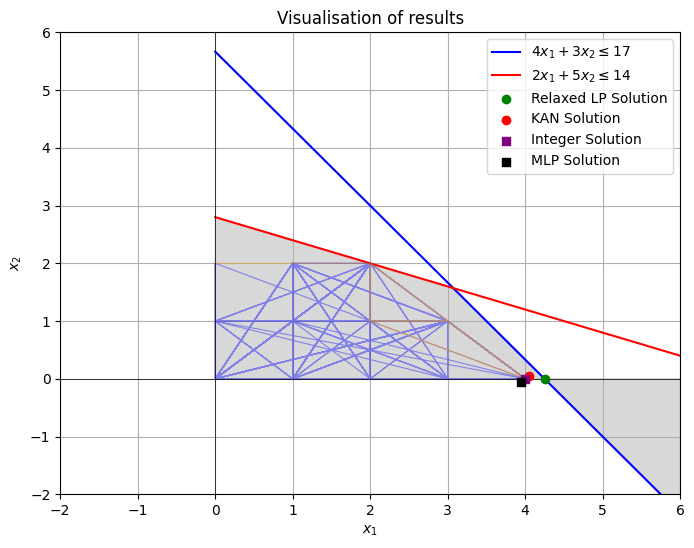

In [ ]:
#same as above except we see the paths taken
xVals = np.linspace(0, 10, 200)
y1Vals = (17 - 4*xVals) / 3
y2Vals = (14 - 2*xVals) / 5

offset = 0.05
plt.figure(figsize=(8, 6))
plt.plot(xVals, y1Vals, label=r"$4x_1 + 3x_2 \leq 17$", color="blue")
plt.plot(xVals, y2Vals, label=r"$2x_1 + 5x_2 \leq 14$", color="red")
plt.fill_between(xVals, np.minimum(y1Vals, y2Vals), 0, color="gray", alpha=0.3)
#mlp path taken
for runCoords in mlpAllCoordinates[:1]:
    runCoords = np.array(runCoords)
    plt.plot(runCoords[:,0],runCoords[:,1], alpha=0.4, color='blue', linewidth=0.8)

#kan path taken
for runCoords in kanAllCoordinates[:1]:
    runCoords = np.array(runCoords)
    plt.plot(runCoords[:,0],runCoords[:,1], alpha=0.4, color='orange', linewidth=0.8)

plt.scatter(x1LP, x2LP, color="green", label="Relaxed LP Solution", zorder=3)
plt.scatter(kanBestX1+offset, kanBestX2+offset, color="red", label="KAN Solution", zorder=3)
plt.scatter(x1Int, x2Int, color="purple", label="Integer Solution", zorder=3, marker="s")
plt.scatter(mlpBestX1-offset, mlpBestX2-offset, color="black", label="MLP Solution", zorder=3, marker="s")

plt.xlim(-2, 6)
plt.ylim(-2, 6)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.title("Visualisation of results")
plt.grid()
plt.show()